In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import Reader
from collections import defaultdict

### 1. Read and explore the given dataset.  (Rename column/add headers, plot histograms, find data characteristics

In [2]:
data = pd.read_csv('ratings_Electronics.csv',names=['user_id','product_id','ratings','timestamp'])
data.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
user_id       object
product_id    object
ratings       float64
timestamp     int64
dtypes: float64(1), int64(1), object(2)
memory usage: 179.1+ MB


In [4]:
data.isnull().sum()

user_id       0
product_id    0
ratings       0
timestamp     0
dtype: int64

In [5]:
data.describe()

,ratings,timestamp
count,7.824482e+06,7.824482e+06
mean,4.012337e+00,1.338178e+09
std,1.380910e+00,6.900426e+07
min,1.000000e+00,9.127296e+08
25%,3.000000e+00,1.315354e+09
50%,5.000000e+00,1.361059e+09
75%,5.000000e+00,1.386115e+09
max,5.000000e+00,1.406074e+09


In [6]:
data.shape

(7824482, 4)

In [8]:
data['product_id'].value_counts()

B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
              ...  
B000KZCFD0        1
B003NYUUDW        1
B008GXODB0        1
B00HNL76JM        1
B00ICV0D6A        1
Name: product_id, Length: 476002, dtype: int64

In [10]:
data['product_id'].describe() # list of unique product values in dataset

count        7824482
unique        476002
top       B0074BW614
freq           18244
Name: product_id, dtype: object

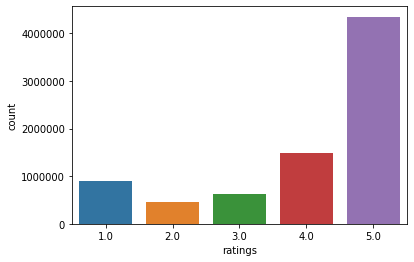

In [11]:
sn.countplot(data['ratings'])

In [ ]:
# plot distribution plot afterwards

In [12]:
data.groupby('product_id')['ratings'].mean().head(20)

product_id
0132793040    5.000000
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
059400232X    5.000000
0594012015    2.000000
0594017343    1.000000
0594017580    3.000000
0594033896    4.400000
0594033926    4.533333
0594033934    5.000000
0594202442    4.000000
0594287995    5.000000
0594296420    4.666667
0594450209    5.000000
0594450705    5.000000
0594451647    4.357143
0594477670    4.666667
Name: ratings, dtype: float64

### 2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings ) 

In [13]:
counts = data['user_id'].value_counts()
data_final = data[data['user_id'].isin(counts[counts >= 50].index)]
data_final.shape

(125871, 4)

In [14]:
# how to remove timestamp column
data_final.drop(['timestamp'], axis = 1, inplace = True)
data_final.head()

c:\program files (x86)\python37-32\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,user_id,product_id,ratings
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [ ]:
# So as we can see that now the data set is reduces from 78 lakh records to nearly 1lakh 25 thousand records

### 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) 


In [16]:
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
finaldata = Dataset.load_from_df(data_final, reader=reader)
train_data, test_data = train_test_split(finaldata, test_size=.3)

### 4. Build Popularity Recommender model. - (20 Marks)

In [17]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = data_final.groupby('product_id').agg({'user_id': 'count'}).reset_index()

train_data_grouped.head(10)

,product_id,user_id
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6
5,1400501520,1
6,1400501776,2
7,1400532620,2
8,1400532655,6
9,140053271X,2


In [19]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['user_id', 'product_id'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['user_id'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,product_id,user_id,Rank
39003,B0088CJT4U,206,1.0
24827,B003ES5ZUU,184,2.0
11078,B000N99BBC,167,3.0
38250,B007WTAJTO,164,4.0
38615,B00829TIEK,149,5.0


In [20]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [21]:
find_recom = [155,11,72]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 155

       Rank  product_id  user_id
39003   1.0  B0088CJT4U      155
24827   2.0  B003ES5ZUU      155
11078   3.0  B000N99BBC      155
38250   4.0  B007WTAJTO      155
38615   5.0  B00829TIEK      155


Here is the recommendation for the userId: 11

       Rank  product_id  user_id
39003   1.0  B0088CJT4U       11
24827   2.0  B003ES5ZUU       11
11078   3.0  B000N99BBC       11
38250   4.0  B007WTAJTO       11
38615   5.0  B00829TIEK       11


Here is the recommendation for the userId: 72

       Rank  product_id  user_id
39003   1.0  B0088CJT4U       72
24827   2.0  B003ES5ZUU       72
11078   3.0  B000N99BBC       72
38250   4.0  B007WTAJTO       72
38615   5.0  B00829TIEK       72




c:\program files (x86)\python37-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 8. Summarise your insights- Part 1

####  1. Popularity Based recommendation is irrespective of user, it will give all the user whether new or old the same information of the products that are mostly purchased. you can check with the above test as all the three users were recommended the same product which were mostly purchased

#### 2. The Popularity-based recommender system is non-personalised and the recommendations are based on frequecy counts, which may be not suitable to the user.

### 5. Building Collaborative Filtering

In [22]:
reader = Reader(line_format='user item rating', sep='\t', rating_scale = (1,5))
finaldata = Dataset.load_from_df(data_final, reader=reader)
train_data, test_data = train_test_split(finaldata, test_size=.3)

### User-User Collaborative

In [23]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [24]:
test_pred_User = algo.test(test_data)

In [37]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred_User, verbose=True)
accuracy.mse(test_pred_User, verbose=True)


User-based Model : Test Set
RMSE: 1.0463
MSE: 1.0948


1.0947769082186243

### Item Item Collaborative Filtering

In [39]:
algo = KNNWithMeans(k=10 , sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(train_data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...


ValueError: array is too big; `arr.size * arr.dtype.itemsize` is larger than the maximum possible size.

In [27]:
test_pred_Item = algo.test(test_data)

AttributeError: 'KNNWithMeans' object has no attribute 'sim'

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred_Item, verbose=True)

### 6. Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (RMSE) on predictions made on the test data.) 

####  1. Higher value of RMSE indicates veryless error in the recommendation. Since the recommendation was to predict new products to user an item to item collab filtering will give better results

####  Issue: I am unable to find actual RMSE for item item filtering due to above errors


### 7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products for each user based on his/her habits, we will recommend 5 new products.

In [28]:
algo = SVD()
algo.fit(train_data)
predictions = algo.test(test_data)

In [29]:
def get_top_recommendation(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [34]:
top_n = get_top_recommendation(predictions, n=5)
top_n

defaultdict(list,
            {'A3HR0ZZOFKQ97N': [('B0019EHU8G', 5),
              ('B003KPBRRW', 4.7754692802435965),
              ('B0001Y7UAI', 4.769724440618223),
              ('B007W0XHK6', 4.769583427972137),
              ('B00834SJNA', 4.766898871477023)],
             'A1PAGHECG401K1': [('B003VANO7C', 4.590872819430492),
              ('B00FA4Y7N2', 4.306162651761046),
              ('B003QFXP3U', 4.280328236133114),
              ('B005TI1ILS', 4.223625262126623),
              ('B004WITQ9C', 4.198641558556644)],
             'A1VR1HIOVQWN09': [('B0019EHU8G', 5),
              ('B004GF8TIK', 4.976079244503751),
              ('B00478O0JI', 4.861122882878977),
              ('B0009ON12G', 4.827508957830715),
              ('B004LSNF04', 4.742171990259449)],
             'AAR7CEPXYJA0T': [('B001FWBUUG', 4.104992776629546),
              ('B001IAYUM0', 4.024065497068934),
              ('B003HIXOOG', 3.98921354115987),
              ('B0012W7HQK', 3.939111338897894),
         

In [31]:
defaultdict# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A3HR0ZZOFKQ97N ['B0019EHU8G', 'B003KPBRRW', 'B0001Y7UAI', 'B007W0XHK6', 'B00834SJNA']
A1PAGHECG401K1 ['B003VANO7C', 'B00FA4Y7N2', 'B003QFXP3U', 'B005TI1ILS', 'B004WITQ9C']
A1VR1HIOVQWN09 ['B0019EHU8G', 'B004GF8TIK', 'B00478O0JI', 'B0009ON12G', 'B004LSNF04']
AAR7CEPXYJA0T ['B001FWBUUG', 'B001IAYUM0', 'B003HIXOOG', 'B0012W7HQK', 'B002ZCXJZE']
A1FXT4VNDA25LY ['B0000BZL1P', 'B000CKVOOY', 'B0087QK9TG', 'B005D2JE2A', 'B0015MFTE4']
APOGXH3A74CM3 ['B000M2GYF6', 'B002SFDJMQ', 'B000068BRE', 'B003WV5DJC', 'B000JO1IPI']
A35Q0RBM3YNQNF ['B0079UAT0A', 'B00KYMCJF8', 'B00ISIG690', 'B00ISKS402', 'B00DQKQ7U8']
A1GBT4UN2RW7XY ['B004GXAL42', 'B006J1ZAR2', 'B00004T8R2', 'B0064XAIZY', 'B00BGA9WK2']
A1QOK9LU90ACF7 ['B001IEZX3G', 'B004GF1PC2', 'B00KXAFYZS', 'B002SFDJMQ', 'B0095P2F1S']
A225G2TFM76GYX ['B00DT04I9W', 'B001F7AHOG', 'B006DDT6JO', 'B002EEP3MK', 'B001PIBE8I']
A20L63B48RPSOH ['B00ESYW40S', 'B002TLTE7I', 'B006GDTTM0', 'B00834SJNA', 'B005IHAIC0']
A1UEL5C1N6E5SE ['B0011Z44UA', 'B0017HF3XO', 'B000BONJXU'

A3077MQTAKOVFZ ['B0088PUEPK', 'B00762YNMG', 'B000ZJZ7OA', 'B003WV8PKG', 'B000BKBZGC']
A2JAEZ0FMAMJVW ['B00FR6VL50', 'B00IVFDZBC', 'B005O9YMM4', 'B000H94W4O', 'B006JH8T3S']
A356RFKNIG043B ['B005E8MVV4', 'B00JFAA97A', 'B0011ZCDKS', 'B005INAU90', 'B00001P4ZH']
AM8W6Y3HVXLZT ['B00D6XW62I', 'B0053G6GI6', 'B003V57TBY', 'B00FPKDPZC', 'B00009X75L']
AM0QLU79O05JR ['B000AY5Y5W', 'B00834SJNA', 'B00DVHP478', 'B002JPITXY', 'B00IVEHCVW']
A15TABNGK6L4N3 ['B00005T3G0', 'B001N9X4CS', 'B004Z0S6RU', 'B00139W0XM', 'B002SZEOLG']
APBDZ88BBTN4F ['B00511PS3C', 'B003N7NMO8', 'B00FNPD1OY', 'B0079R8KO0', 'B004X1IQAS']
A2JCJJNY43QQIV ['B002TLTE6O', 'B002K9IHGI', 'B003WV8PKG', 'B00141AYIC', 'B004WOK2NK']
A1YE1IK0JYSIIE ['B00GOX22WQ', 'B0027EMHM6', 'B004I1GHY0', 'B0074GWJ7A', 'B00EON44M4']
A368IPE6EW0GZL ['B003IVXPMS', 'B000CLNHXY', 'B005HGBEZ2', 'B0013J5XZE', 'B0016J1EC2']
AG2YXYIQ8TLTA ['B000N99BBC', 'B0055QZ216', 'B00BUER7EC', 'B000RZ8WHG', 'B006ZBWV0K']
A1I96OYAUJ3HQE ['B00007B4DM', 'B0041PO3DU', 'B001UFYFYG', 

### 8. Summarise your insights- Part 2

#### 1. unlike popularity based collaborative filtering is personalized based filtering and instead of suggesting same product to each user it is recommending list of different products to each user based on past experience